Link to Drive for CDs dataset: https://drive.google.com/drive/folders/1t2Y24NSpGlT2M29zJUDvvEg2KfP0JqkN?usp=share_link

# Preprocessing...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
import torch.nn.functional as F
np.random.seed(0)

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/CDs_and_Vinyl.json.gz --no-check-certificate 

--2023-01-17 07:49:50--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/CDs_and_Vinyl.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1172666826 (1.1G) [application/x-gzip]
Saving to: ‘CDs_and_Vinyl.json.gz’

CDs_and_Vinyl.json. 100%[===================>]   1.09G  57.0MB/s    in 20s     

2023-01-17 07:50:10 (55.8 MB/s) - ‘CDs_and_Vinyl.json.gz’ saved [1172666826/1172666826]



In [ ]:
!gunzip CDs_and_Vinyl.json.gz

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_CDs_and_Vinyl.json.gz --no-check-certificate 

--2023-01-17 07:50:50--  https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_CDs_and_Vinyl.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 161716387 (154M) [application/x-gzip]
Saving to: ‘meta_CDs_and_Vinyl.json.gz’

meta_CDs_and_Vinyl. 100%[===================>] 154.22M  50.4MB/s    in 3.1s    

2023-01-17 07:50:53 (50.4 MB/s) - ‘meta_CDs_and_Vinyl.json.gz’ saved [161716387/161716387]



In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import pandas as pd

In [ ]:
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/'

In [ ]:
save_path2='/content/drive/MyDrive/CDs'

In [ ]:
df_review=pd.read_csv(save_path+'df_reviews.csv')

In [ ]:
df_meta=pd.read_csv(save_path+'df_meta.csv')

In [ ]:
import glob
items_list=[]
names=glob.glob(save_path+"descriptions_bert/*.json")
for name in names:
  # items_dframe=pd.read_json(name)
  item_id=name.split('/')[-1].split('_')[-1][0:-5]
  items_list.append(item_id)


In [ ]:
print('B014QE0N8O' in items_list)

In [ ]:
len(items_list)

In [ ]:
df_review.drop(df_review.index[~df_review['asin'].isin(items_list)], inplace=True) 

In [ ]:
# df_review=df_review[df_review['reviewerID'].isin(df_review['reviewerID'].value_counts()[df_review['reviewerID'].value_counts()>=5].index)]
# df_review=df_review[df_review['asin'].isin(df_review['asin'].value_counts()[df_review['asin'].value_counts()>=10].index)]

In [ ]:
df_review.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df_review

,reviewerID,asin,overall,unixReviewTime
0,AV3DKV2TW5B3C,0005164885,5.0,1515542400
1,A1TBCT7195A7IU,0005164885,5.0,1501718400
2,A30M3WWF54M74L,0005164885,5.0,1483920000
3,A2OE456EJT10IH,0005164885,5.0,1482364800
4,A3LEN0P07MGJE2,0005164885,5.0,1480723200
...,...,...,...,...
657816,A1W0CL8UCLAR9N,B01HE8WDP0,5.0,1522800000
657817,A130THBTY1SYY,B01HE8WDP0,3.0,1522281600
657827,A2WXKHN6J2P4OO,B01HEYDFJC,4.0,1520553600
657828,A1LMML5XIDEMFE,B01HEYDFJC,1.0,1487289600


In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'CDs_and_Vinyl')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in items_list:
    users_list.append(user_id)
    items_list1.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
          feature = fos.split('|')[0]
          opinion = fos.split('|')[1]
          sentiment = fos.split('|')[2]
          sentence= seg.split(':')[1]
          if sentiment=='+1':
            senti=1
          else:
            senti=-1
          review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000


In [ ]:
df_review=df_review[df_review.set_index(['reviewerID','asin']).index.isin(review_features.keys())]

In [ ]:
df_review

,reviewerID,asin,overall,unixReviewTime
4,A3LEN0P07MGJE2,0005164885,5.0,1480723200
20,A2PBPFPMTEZYKP,0005164885,4.0,1425081600
26,A1XETBGQF7SK2J,0005164885,1.0,1389052800
27,A2LYK2N9IHPGZB,0005164885,5.0,1388966400
33,A2GT0MCMRKLKDW,0005164885,5.0,1356998400
...,...,...,...,...
657736,A2TMHQYC6K0AGP,B01H4G3J1Y,3.0,1509062400
657777,A175BNUPT0T43G,B01HC94ADO,4.0,1516838400
657778,A1FRMHI8CS0Z3,B01HC94ADO,4.0,1515369600
657814,A32UZE5D7LPH8L,B01HE8WDP0,5.0,1530835200


In [ ]:
sentires_dir='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/CDs_and_Vinyl'
test_length=10
sample_ratio=5
val_length=5
neg_length=100
dataset='cds'
save_path='/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/'

In [ ]:
def get_user_item_dict(df_review,items_list):
  user_dict = {}
  item_dict = {}
  j=0
  # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']    
  for index, row in df_review.iterrows():
    if j%100000==0:
      print(j)
    j+=1
    user=row['reviewerID']
    item=row['asin']
    if item in items_list:
      if user not in user_dict:
          user_dict[user] = [item]
      else:
          user_dict[user].append(item)
      if item not in item_dict:
          item_dict[item] = [user]
      else:
          item_dict[item].append(user)
  return user_dict,item_dict

In [ ]:
df_meta.loc[df_meta['feature'].str.len()<15]

In [ ]:
def get_average_vect_train(df,not_in_columns):
  df1=df.copy()
  df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
  df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==5.0,1,0)
    df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==12.0,1,0)
    df1=df1[df1['main_word']==1]
  lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df1[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  average=np.average(np.array(vects),axis=0)
  # print(vects)
  # print(average)
  # print(df)
  # print(words)
  # print(df)
  return average,list(words)

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
import os

In [ ]:
from typing_extensions import final
def get_item_matrix(item_name_dict,items_list):
  print('----- get items matrix -------')
  item_quality_matrix = np.zeros((len(item_name_dict), 1536))
  print((len(item_name_dict)))
  i=0
  features={}
  for item_id in items_list:
    if item_id in item_name_dict.keys():
      item=item_name_dict[item_id]
      features[item]=[]
      if i%100==0:
        print(i)
      i+=1
      # if i<950:
      #   continue
      final_vector=[]
      # print(item_id)
      df_vect_desc_item= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format(item_id))
      df_vect_title_item= pd.read_json(save_path+'titles_bert/'+'{}.json'.format(item_id))
      # df_vect_feature_item= pd.read_json(save_path+'features_bert/'+'{}.json'.format(item_id))
      
      # print(item_id)
      # print(df_vect_desc_item)

      average_vect_desc,words_desc=get_average_vect_train(df_vect_desc_item,'description_words')
      average_vect_title,words_title=get_average_vect_train(df_vect_title_item,'title_words')
      # average_vect_feature,words_feature=get_average_vect_train(df_vect_feature_item,'feature_words')
      # print(average_vect_title.shape)
      features[item].append(words_desc)
      features[item].append(words_title)
      # features[item].append(words_feature)
      # features[item].append(words_senti)
      # features[item].append([rank])
      final_vector=list(average_vect_desc)
      final_vector+=list(average_vect_title)
      # final_vector+=list(average_vect_feature)
  # final_vector+=list(average_bert_sentiment)
  # final_vector+=[rank]
  
      if len(final_vector)>1536:
          print(len(list(average_vect_desc)))
          print(len(list(average_vect_title)))
          # print(len(list(average_vect_feature)))
          # print(len(list(average_bert_sentiment)))
          print(item_id)
      item_quality_matrix[item]=final_vector
      # print(item_quality_matrix)

  item_quality_matrix = np.array(item_quality_matrix, dtype='float32')
  return item_quality_matrix,features

In [ ]:
def get_user_matrix(item_matrix,inv_user_name_dict,item_name_dict):
  user_quality_matrix = np.zeros((len(inv_user_name_dict), 1536))
  i=0
  print('----- get users matrix -------')
  print((len(inv_user_name_dict)))
  for  user in inv_user_name_dict.keys():
    if i%1000==0:
      print(i)
    i+=1
    user_id= inv_user_name_dict[user]
    final_vector=[]
    items_interacted=df_review[df_review['reviewerID']==user_id ]
    # mean_rate=np.average(items_interacted['overall'].values)
    # weights=[]
    for item_id in items_interacted['asin'].values:
      if item_id in item_name_dict.keys():
        item=item_name_dict[item_id]
        # weight=items_interacted[items_interacted['asin']==item_id]['overall'].values[0]-mean_rate
        # weights.append(weight)
        final_vector.append(item_matrix[item])
    # if np.sum(weights)>0 or np.sum(weights)<0:
    #   final_average=np.average(final_vector,weights=weights,axis=0)
    # else:
    final_average=np.average(final_vector,axis=0)
    if ~np.isnan(np.sum(final_average)):
      user_quality_matrix[user]=final_average
    else:
      print(user_id)
  user_quality_matrix = np.array(user_quality_matrix, dtype='float32')
  return user_quality_matrix

In [ ]:
def sample_training_pairs(user, training_items, item_set, sample_ratio=5):
    positive_items = set(training_items)
    negative_items = set()
    for item in item_set:
        if item not in positive_items:
            negative_items.add(item)
    neg_length = len(positive_items) * sample_ratio
    negative_items = np.random.choice(np.array(list(negative_items)), neg_length, replace=False)
    train_pairs = []
    for p_item in positive_items:
        train_pairs.append([user, p_item, 1])
    for n_item in negative_items:
        train_pairs.append([user, n_item, 0])
    return train_pairs

In [ ]:
user_dict,item_dict=get_user_item_dict(df_review,items_list)

0
100000
200000


In [ ]:
from re import S
import torch
import numpy as np
import json
import pickle
# from torch._C import R
import tqdm
from torch.random import seed


class AmazonDataset():
    def __init__(self):
        super().__init__()

        self.user_name_dict = {}  # rename users to integer names
        self.item_name_dict = {}
        # self.feature_name_dict = {}

        self.features = {}  # feature list
        self.users = []
        self.items = []

        # the interacted items for each user, sorted with date {user:[i1, i2, i3, ...], user:[i1, i2, i3, ...]}
        self.user_hist_inter_dict = {}
        # the interacted users for each item
        self.item_hist_inter_dict = {}  

        self.user_num = None
        self.item_num = None
        self.feature_num = 1536# number of features

        self.user_feature_matrix = None  # user aspect attention matrix
        self.item_feature_matrix = None  # item aspect quality matrix

        self.training_data = None
        self.test_data = None
        self.pre_processing()
        self.get_user_item_feature_matrix()
        self.sample_training()  # sample training data, for traning BPR loss
        self.sample_test()  # sample test data

    def pre_processing(self,):
        self.items_list=items_list
        user_dict, item_dict = get_user_item_dict(df_review,self.items_list)  # not sorted with time
        self.items_list=list(item_dict.keys())
        print('num_items: ',len(item_dict))
        user_item_date_dict = {}   # {(user, item): date, (user, item): date ...}  # used to remove duplicate
        # # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']
        # print(df_review.shape)
        for i, row in df_review.iterrows():
            user = row['reviewerID']
            # if user not in removed_users:
            item = row['asin']
            date = row['unixReviewTime']
            if item in self.items_list:
              if user in user_dict and item in user_dict[user] and (user, item) not in user_item_date_dict:
                  user_item_date_dict[(user, item)] = date
        
        # rename users, items, and features to integer names
        user_name_dict = {}
        item_name_dict = {}
        # feature_name_dict = {}
        # features = get_feature_list(df_bert_sentiment,df_bert_desc,)
        
        count = 0
        for user in user_dict:
            if user not in user_name_dict:
                user_name_dict[user] = count
                count += 1
        count = 0
        for item in item_dict:
            if item not in item_name_dict:
                item_name_dict[item] = count
                count += 1
        self.inv_user_name_dict = {v: k for k, v in user_name_dict.items()}
        self.inv_item_name_dict = {v: k for k, v in item_name_dict.items()}
        

        renamed_user_item_date_dict = {}
        for key, value in user_item_date_dict.items():
            renamed_user_item_date_dict[user_name_dict[key[0]], item_name_dict[key[1]]] = value

        # sort with date
        renamed_user_item_date_dict  = dict(sorted(renamed_user_item_date_dict .items(), key=lambda item: item[1]))

        user_hist_inter_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}, sort with time
        item_hist_inter_dict = {}
        # ranked_user_item_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}
        for key, value in renamed_user_item_date_dict.items():
            user = key[0]
            item = key[1]
            if user not in user_hist_inter_dict:
                user_hist_inter_dict[user] = [item]
            else:
                user_hist_inter_dict[user].append(item)
            if item not in item_hist_inter_dict:
                item_hist_inter_dict[item] = [user]
            else:
                item_hist_inter_dict[item].append(user)

        user_hist_inter_dict = dict(sorted(user_hist_inter_dict.items()))
        item_hist_inter_dict = dict(sorted(item_hist_inter_dict.items()))

        users = list(user_hist_inter_dict.keys())
        items = list(item_hist_inter_dict.keys())

        self.user_name_dict = user_name_dict
        self.item_name_dict = item_name_dict
        self.user_hist_inter_dict = user_hist_inter_dict
        self.item_hist_inter_dict = item_hist_inter_dict
        self.users = users
        self.items = items
        self.user_num = len(users)
        self.item_num = len(items)
        return True
    
    def get_user_item_feature_matrix(self,):
        # exclude test data from the sentiment data to construct matrix
        train_u_i_set = set()
        for user, items in self.user_hist_inter_dict.items():
            items = items[:-test_length]
            for item in items:
                train_u_i_set.add((user, item))

        self.item_feature_matrix,self.item_features= get_item_matrix(self.item_name_dict,self.items_list)
        self.user_feature_matrix = get_user_matrix(self.item_feature_matrix,self.inv_user_name_dict,self.item_name_dict)
        
        return True
    
    def sample_training(self):
        print('======================= sample training data =======================')
        # training_data = []
        # training_pairs = np.loadtxt(save_path+'training_data.txt',dtype=str)
        # for pair in training_pairs:
        #   # print(self.user_name_dict)
        #   # print(pair[0])
        #   if pair[0] in self.user_name_dict.keys() and pair[1] in self.item_name_dict.keys():
        #     training_data.append([self.user_name_dict[pair[0]],self.item_name_dict[pair[1]],int(pair[2])])


        print(self.user_feature_matrix.shape, self.item_feature_matrix.shape)
        training_data = []
        item_set = set(self.items)
        for user, items in self.user_hist_inter_dict.items():
            if len(items)>15:
              items = items[:-(test_length)]
              training_pairs = sample_training_pairs(
                  user, 
                  items, 
                  item_set, 
                  sample_ratio)
              for pair in training_pairs:
                  training_data.append(pair)
        print('# training samples :', len(training_data))
        self.training_data = np.array(training_data)
      
        return True
    
    def sample_test(self):
        print('======================= sample test data =======================')
        # user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'test_data.pickle', 'rb') as f:
        #     test_pairs= pickle.load(f)
        # for user_id in test_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=test_pairs[user_id][0]
        #   labels=test_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   user_item_label_list.append([user,items,labels])
        # print('# test samples :', len(user_item_label_list))
        # self.test_data = np.array(user_item_label_list)

        # validation_data = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'validation_data.pickle', 'rb') as f:
        #     validation_pairs= pickle.load(f)
        # for user_id in validation_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=validation_pairs[user_id][0]
        #   labels=validation_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   validation_data.append([user,items,labels])
        # print('# validation samples :', len(validation_data))
        # self.validation_data = np.array(validation_data)


        user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        validation_data=[]
        for user, items in self.user_hist_inter_dict.items():
          if len(items)>15:
            # print(items)
            items1 = items[-(test_length):-(val_length)]
            items2 = items[-(val_length):]
            # print(items1)
            # print(items2)
            user_item_label_list.append([user, items1, np.ones(len(items1))])  # add the test items
            validation_data.append([user, items2, np.ones(len(items2))])
            neg_length1=len(items1)*5
            neg_length2=len(items2)*5
            negative_items1 = [item for item in self.items if 
                item not in self.user_hist_inter_dict[user]]  # the not interacted items
            # print(len(negative_items1))
            negative_items1 = np.random.choice(np.array(negative_items1), neg_length1, replace=False)
            negative_items2 = np.random.choice(np.array(negative_items1), neg_length2, replace=False)

            user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items1), axis=0)
            user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length1)), axis=0)

            validation_data[-1][1] = np.concatenate((validation_data[-1][1], negative_items2), axis=0)
            validation_data[-1][2] = np.concatenate((validation_data[-1][2], np.zeros(neg_length2)), axis=0)
        print('# test samples :', len(user_item_label_list))
        print('# validation samples :', len(validation_data))
        self.test_data = np.array(user_item_label_list)
        self.validation_data=np.array(validation_data)
        return True

    def save(self, save_path):
        return True
    
    def load(self):
        return False

In [ ]:
def amazon_preprocessing():
    rec_dataset = AmazonDataset()
    return rec_dataset

In [ ]:
def dataset_init():
	if dataset == "yelp":
		rec_dataset = yelp_preprocessing()
	elif dataset == "cell_phones" or "kindle_store" or "electronic" or "cds_and_vinyl":
		rec_dataset = amazon_preprocessing()
	return rec_dataset

In [ ]:
dataset="cds_and_vinyl"
gpu=True
cuda='0'
weight_decay=0.00001
lr=0.01
epochs=85
batch_size=64
rec_k=5

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class UserItemInterDataset(Dataset):
    def __init__(self, data, user_feature_matrix, item_feature_matrix):
        self.data = data
        self.user_feature_matrix = user_feature_matrix
        self.item_feature_matrix = item_feature_matrix

    def __getitem__(self, index):
        user = self.data[index][0]
        item = self.data[index][1]
        label = self.data[index][2]
        user_feature = self.user_feature_matrix[user]
        item_feature = self.item_feature_matrix[item]
        return user_feature, item_feature, label
    def __len__(self):
        return len(self.data)

# Train Black-box model...

In [ ]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

In [ ]:
def compute_ndcg(test_data, user_feature_matrix, item_feature_matrix, k, model, device):
    model.eval()
    ndcgs = []
    with torch.no_grad():
        for row in test_data:
            user = row[0]
            items = row[1]
            gt_labels = row[2]
            user_features = np.array([user_feature_matrix[user] for i in range(len(items))])
            item_features = np.array([item_feature_matrix[item] for item in items])
            scores = model(torch.from_numpy(user_features).to(device),
                                    torch.from_numpy(item_features).to(device)).squeeze()
            # print(scores)
            # print(gt_labels)                        
            scores = np.array(scores.to('cpu'))
            ndcg = ndcg_score([gt_labels], [scores], k=k)
            ndcgs.append(ndcg)
    ave_ndcg = np.mean(ndcgs)
    return ave_ndcg


In [ ]:
import torch
import numpy as np
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [ ]:
from numpy import core

class BaseRecModel(torch.nn.Module):
    def __init__(self, feature_length):
        super(BaseRecModel, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_length * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, user_feature, item_feature):
        fusion = torch.cat((user_feature, item_feature), 1)
        out = self.fc(fusion)
        return out


In [ ]:
if gpu:
  device = torch.device('cuda:%s' % cuda)
else:
  device = 'cpu'
print(device)

cuda:0


In [ ]:
df_vect_desc_item= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format('B0006TIA8Y'))

In [ ]:
df_vect_desc_item

In [ ]:
print(len(items_list))

0


In [ ]:
rec_dataset = dataset_init()

0
100000
200000
num_items:  11677
----- get items matrix -------
11677
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
----- get users matrix -------
11467
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
======================= sample training data =======================
(11467, 1536) (11677, 1536)
# training samples : 686172
======================= sample test data =======================
# test samples : 3631
# validation samples : 3631


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:215: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
Path(save_path).mkdir(parents=True, exist_ok=True)
with open(os.path.join(save_path,dataset + "_dataset_obj_2.pickle"), 'wb') as outp:
   pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
import matplotlib.pyplot as plt

Using CUDA 0
init ndcg: 0.1791600359652303


  0%|          | 0/85 [00:00<?, ?it/s]

epoch 0:  training loss:  0.43739545


  1%|          | 1/85 [00:39<55:22, 39.56s/it]

epoch 0:  training loss:  0.43739545 NDCG_validation:  0.28927914605596006


  2%|▏         | 2/85 [01:15<52:00, 37.59s/it]

epoch 1:  training loss:  0.38772625


  4%|▎         | 3/85 [01:52<50:42, 37.11s/it]

epoch 2:  training loss:  0.3472371


  5%|▍         | 4/85 [02:29<50:05, 37.10s/it]

epoch 3:  training loss:  0.32881412


  6%|▌         | 5/85 [03:02<47:39, 35.75s/it]

epoch 4:  training loss:  0.31665444


  7%|▋         | 6/85 [03:35<45:55, 34.88s/it]

epoch 5:  training loss:  0.30723634


  8%|▊         | 7/85 [04:10<45:05, 34.69s/it]

epoch 6:  training loss:  0.29987782


  9%|▉         | 8/85 [04:43<43:53, 34.20s/it]

epoch 7:  training loss:  0.2935726


 11%|█         | 9/85 [05:16<42:51, 33.83s/it]

epoch 8:  training loss:  0.28797266


 12%|█▏        | 10/85 [05:49<42:04, 33.65s/it]

epoch 9:  training loss:  0.28337234
epoch 10:  training loss:  0.2785787


 13%|█▎        | 11/85 [06:27<42:55, 34.81s/it]

epoch 10:  training loss:  0.2785787 NDCG_validation:  0.6141507577752919


 14%|█▍        | 12/85 [07:00<41:41, 34.27s/it]

epoch 11:  training loss:  0.27463046


 15%|█▌        | 13/85 [07:33<40:45, 33.97s/it]

epoch 12:  training loss:  0.27067512


 16%|█▋        | 14/85 [08:08<40:25, 34.16s/it]

epoch 13:  training loss:  0.26711112


 18%|█▊        | 15/85 [08:41<39:31, 33.88s/it]

epoch 14:  training loss:  0.26368868


 19%|█▉        | 16/85 [09:14<38:37, 33.59s/it]

epoch 15:  training loss:  0.26046047


 20%|██        | 17/85 [09:47<37:58, 33.50s/it]

epoch 16:  training loss:  0.25732636


 21%|██        | 18/85 [10:21<37:36, 33.68s/it]

epoch 17:  training loss:  0.2544511


 22%|██▏       | 19/85 [10:54<36:44, 33.40s/it]

epoch 18:  training loss:  0.25168663


 24%|██▎       | 20/85 [11:27<36:00, 33.23s/it]

epoch 19:  training loss:  0.24889404
epoch 20:  training loss:  0.2463181


 25%|██▍       | 21/85 [12:02<36:16, 34.01s/it]

epoch 20:  training loss:  0.2463181 NDCG_validation:  0.6425186897964531


 26%|██▌       | 22/85 [12:36<35:34, 33.89s/it]

epoch 21:  training loss:  0.24376343


 27%|██▋       | 23/85 [13:10<35:11, 34.05s/it]

epoch 22:  training loss:  0.24127959


 28%|██▊       | 24/85 [13:43<34:13, 33.67s/it]

epoch 23:  training loss:  0.23884788


 29%|██▉       | 25/85 [14:17<33:45, 33.76s/it]

epoch 24:  training loss:  0.23635136


 31%|███       | 26/85 [14:51<33:09, 33.72s/it]

epoch 25:  training loss:  0.23373874


 32%|███▏      | 27/85 [15:24<32:19, 33.44s/it]

epoch 26:  training loss:  0.23216362


 33%|███▎      | 28/85 [15:56<31:34, 33.24s/it]

epoch 27:  training loss:  0.22949477


 34%|███▍      | 29/85 [16:31<31:15, 33.50s/it]

epoch 28:  training loss:  0.22762978


 35%|███▌      | 30/85 [17:03<30:27, 33.23s/it]

epoch 29:  training loss:  0.22566341
epoch 30:  training loss:  0.22314729


 36%|███▋      | 31/85 [17:39<30:38, 34.05s/it]

epoch 30:  training loss:  0.22314729 NDCG_validation:  0.643102365431121


 38%|███▊      | 32/85 [18:13<30:03, 34.02s/it]

epoch 31:  training loss:  0.22134638


 39%|███▉      | 33/85 [18:46<29:07, 33.60s/it]

epoch 32:  training loss:  0.21947639


 40%|████      | 34/85 [19:19<28:23, 33.40s/it]

epoch 33:  training loss:  0.21752976


 41%|████      | 35/85 [19:52<27:45, 33.31s/it]

epoch 34:  training loss:  0.21536733


 42%|████▏     | 36/85 [20:27<27:35, 33.78s/it]

epoch 35:  training loss:  0.21362346


 44%|████▎     | 37/85 [21:00<26:51, 33.58s/it]

epoch 36:  training loss:  0.21169429


 45%|████▍     | 38/85 [21:32<26:07, 33.34s/it]

epoch 37:  training loss:  0.20946756


 46%|████▌     | 39/85 [22:05<25:24, 33.14s/it]

epoch 38:  training loss:  0.20820358


 47%|████▋     | 40/85 [22:39<24:54, 33.21s/it]

epoch 39:  training loss:  0.20627575
epoch 40:  training loss:  0.20411249


 48%|████▊     | 41/85 [23:14<24:54, 33.97s/it]

epoch 40:  training loss:  0.20411249 NDCG_validation:  0.6594629556628678


 49%|████▉     | 42/85 [23:47<24:03, 33.57s/it]

epoch 41:  training loss:  0.20263413


 51%|█████     | 43/85 [24:21<23:33, 33.64s/it]

epoch 42:  training loss:  0.20091319


 52%|█████▏    | 44/85 [24:53<22:46, 33.32s/it]

epoch 43:  training loss:  0.1992096


 53%|█████▎    | 45/85 [25:26<22:03, 33.09s/it]

epoch 44:  training loss:  0.19719496


 54%|█████▍    | 46/85 [25:59<21:30, 33.09s/it]

epoch 45:  training loss:  0.19576603


 55%|█████▌    | 47/85 [26:33<21:03, 33.25s/it]

epoch 46:  training loss:  0.1938979


 56%|█████▋    | 48/85 [27:05<20:22, 33.04s/it]

epoch 47:  training loss:  0.19207977


 58%|█████▊    | 49/85 [27:38<19:46, 32.96s/it]

epoch 48:  training loss:  0.19070444


 59%|█████▉    | 50/85 [28:12<19:21, 33.18s/it]

epoch 49:  training loss:  0.18918678
epoch 50:  training loss:  0.18729036


 60%|██████    | 51/85 [28:48<19:18, 34.08s/it]

epoch 50:  training loss:  0.18729036 NDCG_validation:  0.6649643007533451


 61%|██████    | 52/85 [29:21<18:31, 33.69s/it]

epoch 51:  training loss:  0.1858156


 62%|██████▏   | 53/85 [29:53<17:47, 33.37s/it]

epoch 52:  training loss:  0.18395092


 64%|██████▎   | 54/85 [30:27<17:17, 33.47s/it]

epoch 53:  training loss:  0.18294165


 65%|██████▍   | 55/85 [31:00<16:39, 33.30s/it]

epoch 54:  training loss:  0.18061814


 66%|██████▌   | 56/85 [31:32<16:00, 33.11s/it]

epoch 55:  training loss:  0.1795655


 67%|██████▋   | 57/85 [32:05<15:23, 32.97s/it]

epoch 56:  training loss:  0.1779018


 68%|██████▊   | 58/85 [32:39<14:55, 33.18s/it]

epoch 57:  training loss:  0.17582725


 69%|██████▉   | 59/85 [33:11<14:17, 32.97s/it]

epoch 58:  training loss:  0.17476352


 71%|███████   | 60/85 [33:44<13:40, 32.81s/it]

epoch 59:  training loss:  0.17321354
epoch 60:  training loss:  0.1717638


 72%|███████▏  | 61/85 [34:21<13:38, 34.10s/it]

epoch 60:  training loss:  0.1717638 NDCG_validation:  0.6682043695299347


 73%|███████▎  | 62/85 [34:53<12:53, 33.62s/it]

epoch 61:  training loss:  0.17059273


 74%|███████▍  | 63/85 [35:26<12:12, 33.30s/it]

epoch 62:  training loss:  0.16887441


 75%|███████▌  | 64/85 [35:58<11:34, 33.06s/it]

epoch 63:  training loss:  0.16733223


 76%|███████▋  | 65/85 [36:32<11:03, 33.20s/it]

epoch 64:  training loss:  0.16621023


 78%|███████▊  | 66/85 [37:05<10:28, 33.08s/it]

epoch 65:  training loss:  0.16462065


 79%|███████▉  | 67/85 [37:37<09:52, 32.89s/it]

epoch 66:  training loss:  0.16305518


 80%|████████  | 68/85 [38:11<09:24, 33.20s/it]

epoch 67:  training loss:  0.16169171


 81%|████████  | 69/85 [38:43<08:47, 32.96s/it]

epoch 68:  training loss:  0.16055244


 82%|████████▏ | 70/85 [39:16<08:11, 32.79s/it]

epoch 69:  training loss:  0.15834317
epoch 70:  training loss:  0.15756197


 84%|████████▎ | 71/85 [39:52<07:51, 33.67s/it]

epoch 70:  training loss:  0.15756197 NDCG_validation:  0.6727197976694045


 85%|████████▍ | 72/85 [40:25<07:17, 33.66s/it]

epoch 71:  training loss:  0.15610145


 86%|████████▌ | 73/85 [40:58<06:39, 33.32s/it]

epoch 72:  training loss:  0.1548526


 87%|████████▋ | 74/85 [41:30<06:03, 33.07s/it]

epoch 73:  training loss:  0.15335396


 88%|████████▊ | 75/85 [42:03<05:29, 32.95s/it]

epoch 74:  training loss:  0.15163004


 89%|████████▉ | 76/85 [42:36<04:57, 33.10s/it]

epoch 75:  training loss:  0.1502736


 91%|█████████ | 77/85 [43:09<04:23, 32.94s/it]

epoch 76:  training loss:  0.14899254


 92%|█████████▏| 78/85 [43:42<03:50, 32.87s/it]

epoch 77:  training loss:  0.14774486


 93%|█████████▎| 79/85 [44:15<03:18, 33.15s/it]

epoch 78:  training loss:  0.1465145


 94%|█████████▍| 80/85 [44:48<02:44, 32.96s/it]

epoch 79:  training loss:  0.14534166
epoch 80:  training loss:  0.14415772


 95%|█████████▌| 81/85 [45:24<02:15, 33.77s/it]

epoch 80:  training loss:  0.14415772 NDCG_validation:  0.6751946320477029


 96%|█████████▋| 82/85 [45:56<01:40, 33.37s/it]

epoch 81:  training loss:  0.14264402


 98%|█████████▊| 83/85 [46:30<01:06, 33.49s/it]

epoch 82:  training loss:  0.14173189


 99%|█████████▉| 84/85 [47:02<00:33, 33.22s/it]

epoch 83:  training loss:  0.14011623


100%|██████████| 85/85 [47:35<00:00, 33.60s/it]

epoch 84:  training loss:  0.1386456



ndcg_test:  0.7128951765664698


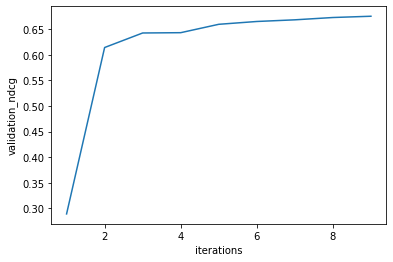

In [ ]:
def train_base_recommendation():
    losses_all=[]
    ndcgs=[]
    if gpu:
        device = torch.device('cuda:%s' % cuda)
    else:
        device = 'cpu'
    Path(save_path).mkdir(parents=True, exist_ok=True)
    with open(os.path.join(save_path,dataset + "_dataset_obj_2.pickle"), 'wb') as outp:
        pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

    train_loader = DataLoader(dataset=UserItemInterDataset(rec_dataset.training_data, 
                                rec_dataset.user_feature_matrix, 
                                rec_dataset.item_feature_matrix),
                          batch_size=batch_size,
                          shuffle=True)

    model = BaseRecModel(rec_dataset.feature_num).to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    out_path = os.path.join("./logs", dataset + "_logs")
    Path(out_path).mkdir(parents=True, exist_ok=True)

    ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('init ndcg:', ndcg)
    for epoch in tqdm.trange(epochs):
        model.train()
        optimizer.zero_grad()
        losses = []
        # print(len(train_loader))
        for user_behaviour_feature, item_aspect_feature, label in train_loader:
            user_behaviour_feature = user_behaviour_feature.to(device)
            item_aspect_feature = item_aspect_feature.to(device)
            label = label.float().to(device)
            out = model(user_behaviour_feature, item_aspect_feature).squeeze()
            if len(out.size())==0:
              continue
            # print(user_behaviour_feature)
            # print( item_aspect_feature)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.to('cpu').detach().numpy())
            ave_train = np.mean(np.array(losses))
            losses_all.append(ave_train)
        print('epoch %d: ' % epoch, 'training loss: ', ave_train)
      
        # compute necg
        if epoch % 10 == 0:
            ndcg = compute_ndcg(rec_dataset.validation_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
            print('epoch %d: ' % epoch, 'training loss: ', ave_train, 'NDCG_validation: ', ndcg)

            ndcgs.append(ndcg)
    torch.save(model.state_dict(), os.path.join(save_path, "model2.model"))
    ndcg_test = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('\nndcg_test: ',ndcg_test)
    # plt.xlabel('iterations')
    # plt.ylabel('train_loss')
    # plt.xticks(np.arange(0,len(losses_all),100))
    # plt.plot(np.arange(0,len(losses_all)),losses_all)
    # plt.show()

    plt.xlabel('iterations')
    plt.ylabel('validation_ndcg')
    plt.xticks(np.arange(-2,len(ndcgs)+2,2))
    plt.plot(np.arange(1,len(ndcgs)+1),ndcgs)
    plt.show()
    return rec_dataset


if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)
    if gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] =cuda
        print("Using CUDA",cuda)
    else:
        print("Using CPU")
    rec_dataset=train_base_recommendation()

In [ ]:
training_data=[]
for train_data in rec_dataset.training_data:
  user=train_data[0]
  item=train_data[1]
  label=train_data[2]
  user_id=rec_dataset.inv_user_name_dict[user]
  item_id=rec_dataset.inv_item_name_dict[item]
  training_data.append([user_id,item_id,label])

In [ ]:
np.savetxt('training_data.txt', training_data, fmt='%s')
b = np.loadtxt('training_data.txt',dtype=str)

In [ ]:
import pickle
pet_stats = {'name':"", 'int':1, 'bool':False}

def pet_save(pet,name):
    with open('{}_data.pickle'.format(name), 'wb') as f:
        pickle.dump(pet, f, pickle.HIGHEST_PROTOCOL)

def digimon_load():
    with open('test_data.pickle', 'rb') as f:
        return pickle.load(f)

In [ ]:
testing_data={}
for ts_data in rec_dataset.test_data:
  user=ts_data[0]
  items=ts_data[1]
  labels=ts_data[2]
  # print(user , item, label)
  user_id=rec_dataset.inv_user_name_dict[user]
  items_id=[rec_dataset.inv_item_name_dict[item] for item in items]
  testing_data[user_id]=[items_id,labels]

In [ ]:
pet_save(testing_data,'test')

In [ ]:
validation_data={}
for ts_data in rec_dataset.validation_data:
  user=ts_data[0]
  items=ts_data[1]
  labels=ts_data[2]
  # print(user , item, label)
  user_id=rec_dataset.inv_user_name_dict[user]
  items_id=[rec_dataset.inv_item_name_dict[item] for item in items]
  validation_data[user_id]=[items_id,labels]

In [ ]:
pet_save(validation_data,'validation')

In [ ]:
dataset="cds_and_vinyl"
base_model_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/"
gpu=True
cuda='0'
data_obj_path="/content/drive/Shareddrives/Unlimited Drive | @LicenseMarket/Recommender/cds/"
rec_k=5
lam=100
gam=0.5
alp=0.2
user_mask=False
lr=0.4
step=2000
mask_thresh=0.3
test_num=-1
# save_path="./explanation_objs/"

In [ ]:
import torch
import pickle
import os
from pathlib import Path

# User Perspective Features

In [ ]:
import json
import nltk

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def lemmatization(text):
    result=''
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        # if pos in ['n','a']:   
        result+=wordnet.lemmatize(token,pos)+' '
    return result
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    en_stopwords+=['may','could','that','without','iii','with','and','This','That','Those','These','the','The','brbr','so','it','such']
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result
def remove_punct(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

def remove_tag(text):
    text=' '.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
  chars=['&','%','#','@','^','>','<','\n','\\','\t',';','"','/']
  stwords=stopwords.words('english')
  for ch in chars:
    text=text.replace(ch,' ')
  text=" ".join(text.split())
  # text=text.lower()
  text_tokenized=word_tokenize(text)
  cleaned_text= remove_stopwords(text_tokenized)
  cleaned_text= remove_punct(cleaned_text)
  # cleaned_text=lemmatization(cleaned_text)
  cleaned_text=remove_tag(cleaned_text)
  cleaned_text=remove_urls(cleaned_text)
  cleaned_text=''.join([i for i in cleaned_text ])
  cleaned_text=[word for word in cleaned_text.split(' ') if len(word)>1]
  # print(cleaned_text)
  return ' '.join(cleaned_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def preprocess_text_first(text):
  while '<' in text and '>' in text and text.index('<')<text.index('>'):
    toRemove=text[int(text.index('<')):int(text.index('>'))]+'>'
    text=text.replace(toRemove,' ')
  list_to_replace=['mso','gte','xml','false','#',',','!','-','\'','\"','[',']','/','\\n','\\','span','a-size-base','a-color-secondary','input type','header name','value','=','<a href= javascript:void(0) class= ','{','}','class=','header','<a href= javascript:void(0)','<','>','href',')','(',';','quot','&',':','javascript']
  for char in list_to_replace:
    text=text.replace(char,' ')
  for i in range(15):
    text=text.replace('  ',' ')
  # while 'if' in text and 'endif' in text and text.index('if')<text.index('endif'):
  #   # print(int(text.index('if')),int(text.index('endif')))
  #   toRemove=text[int(text.index('if')):int(text.index('endif'))]+'endif'
  #   text=text.replace(toRemove,' ')
  new_text=''
  for word in text.split(' '):
    if len(word)>1 and len(word)<35:
      new_text+=word+' '
  # new_text=lemmatization(new_text)
  # print(new_text)
  return new_text

In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'CDs_and_Vinyl')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in items_list:
    users_list.append(user_id)
    items_list1.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
            feature = fos.split('|')[0]
            opinion = fos.split('|')[1]
            sentiment = fos.split('|')[2]
            sentence= seg.split(':')[1]
            if sentiment=='+1':
              senti=1
            else:
              senti=-1
            review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000
265000


In [ ]:
user_test_perspective={}
i=0
for (user_id , item_id) in review_features.keys():
  review_feature=review_features[(user_id,item_id)]
  if i%5000==0:
    print(i)
  i+=1
  for features in review_feature:
    sentence=features[3]
    sentence=preprocess_text_first(sentence)
    sentence=preprocess(sentence).lower()
    if (user_id , item_id) not in user_test_perspective.keys():
      final_vect=[]
    final_vect+=sentence.split(' ')
    for word in sentence.split(' '):
      # tokens=list(set(df_words[df_words['word']==word]['tokenized'].values))
      # for token in tokens:
        final_vect+=word.split(' ')
    final_vect=list(set(final_vect))
    new_final_vect=[]
    for word in final_vect:
      if len(word)>1:
        new_final_vect.append(word)
    user_test_perspective[(user_id , item_id)]=new_final_vect

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000


In [ ]:
user_test_perspective

In [ ]:
rec_dataset.inv_item_name_dict[622]

'B00FL6ADNC'

# Train Explaination Generator Model


In [ ]:
temp_min =1.0
ANNEAL_RATE = 0.00003
class ExpOptimizationModel(torch.nn.Module):
    def __init__(self, base_model, rec_dataset, device):
        super(ExpOptimizationModel, self).__init__()
        self.base_model = base_model
        self.rec_dataset = rec_dataset
        self.device = device
        self.u_i_exp_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        self.user_feature_matrix = torch.from_numpy(self.rec_dataset.user_feature_matrix).to(self.device)
        self.item_feature_matrix = torch.from_numpy(self.rec_dataset.item_feature_matrix).to(self.device)
        self.rec_dict, self.user_perspective_test_data = self.generate_rec_dict()
        self.dict_items_cf_feature={}

    def generate_rec_dict(self):
        rec_dict = {}
        correct_rec_dict = {}  # used for user-side evaluation
        for row in self.rec_dataset.test_data:
            user = row[0]
            items = row[1]
            labels = row[2]
            # print(labels)
            # print(items)

            correct_rec_dict[user] = []
            user_features = self.user_feature_matrix[user].repeat(len(items), 1)
            scores = self.base_model(user_features,
                        self.item_feature_matrix[items]).squeeze()
            scores = np.array(scores.to('cpu'))
            sort_index = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
            
            sorted_items = [items[i] for i in sort_index]
            # print(sorted_items)
            # print(np.sort(scores))
            rec_dict[user] = sorted_items
            for i in range(rec_k):  # find the correct items and add to the user side test data
                if labels[sort_index[i]] == 1:
                    correct_rec_dict[user].append(items[sort_index[i]])

        user_perspective_test_data = {}  # {(u, i):f, (u, i): f]}
        # for user, items in correct_rec_dict.items():
        #     for item in items:
        #         user_id=rec_dataset.inv_user_name_dict[user]
        #         item_id=rec_dataset.inv_item_name_dict[item]
        #         feature = user_test_perspective[(user_id, item_id)]
        #         user_perspective_test_data[(user, item)] = feature
        return rec_dict, user_perspective_test_data
    def user_side_evaluation(self):
        ave_pre, ave_rec, ave_f1 = evaluate_user_perspective(self.user_perspective_test_data, self.u_i_exp_dict)
        print('user\'s perspective:')
        print('ave pre: ', ave_pre, '  ave rec: ', ave_rec, '  ave f1: ', ave_f1)
        return ave_pre,ave_rec,ave_f1
    
    def model_side_evaluation(self):
        ave_pn, ave_ps, ave_fns = evaluate_model_perspective(
            self.rec_dict,
            self.u_i_exp_dict,
            self.base_model,
            self.rec_dataset.user_feature_matrix,
            self.rec_dataset.item_feature_matrix,
            rec_k,
            self.dict_items_cf_feature,
            self.device)
        print('model\'s perspective:')
        print('ave PN: ', ave_pn, '  ave PS: ', ave_ps, '  ave F_{NS}: ', ave_fns)  
        return ave_pn , ave_ps , ave_fns
    def generate_explanation(self,lr,temp,a,b,c):
        # u_i_exps_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        exp_nums = []
        exp_complexities = []
        self.no_exp_count = 0
        self.exp_count=0
        if test_num == -1:
            test_num1 = len(list(self.rec_dict.items()))
        else:
            test_num1 = test_num
        count=0
        for user, items in tqdm.tqdm(list(self.rec_dict.items())[:20]):
            count+=1
            # if count<200:
            #   continue
            # if count==2:
            #   break
            items = self.rec_dict[user]
            margin_item = items[rec_k]
            margin_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                            self.item_feature_matrix[margin_item].unsqueeze(0)).squeeze()
            # print(margin_score)
            # if user_mask:
            #     # mask_vec = self.generate_mask(user)
            #     mask_vec = torch.where(self.user_feature_matrix[user]>0, 1., 0.).unsqueeze(0)  # only choose exps from the user cared aspects
            # else:
                
            for item in items[: rec_k]:
                item_id=rec_dataset.inv_item_name_dict[item]
                tensor_vect_desc,tensor_vect_title=get_tensor_vects(item_id)
                self.dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title)
                # print(tensor_vect_desc.shape)
                # print(tensor_vect_title.shape)
                # print(tensor_vect_feature.shape)
                explanation_features_words,explanation_features_words_replaced, exp_num = self.explain(user,item,
                    self.user_feature_matrix[user], 
                    self.item_feature_matrix[item], 
                    margin_score,
                    tensor_vect_desc,tensor_vect_title,lr, temp,a,b,c)
                
                if explanation_features_words==None or len(explanation_features_words)==0:
                    # print('no explanation for user %d and item %d' % (user, item))
                    self.no_exp_count += 1
                else:
                    self.exp_count+=1
                    self.u_i_exp_dict[(user, item)] = (explanation_features_words,explanation_features_words_replaced)
                    # print(explanation_features_words)
                    exp_nums.append(exp_num)
                    # exp_complexities.append(exp_complexity)
            # if count%500==0:
            #   json1 = json.dumps(self.u_i_exp_dict)
            #   f = open("drive/MyDrive/ranjbar/dict{}.json".format(count),"w")
            #   f.write(json1)
            #   f.close()

              
        print('ave num: ', np.mean(exp_nums),  'no_exp_count: ', self.no_exp_count, 'exp_count: ', self.exp_count)
        return  np.mean(exp_nums), self.no_exp_count,  self.exp_count
    
    def explain(self,user,item, user_feature, item_feature, margin_score,tensor_vect_desc,tensor_vect_title, lr, temp,a, b, c):
        self.exp_generator = EXPGenerator(
            self.rec_dataset, 
            self.base_model, 
            user_feature, 
            item_feature, 
            user,
            item,
            margin_score,
            tensor_vect_desc,tensor_vect_title,
            self.device).to(self.device)
        # optimization
        optimizer = torch.optim.SGD(self.exp_generator.parameters(), lr=lr, weight_decay=0)
        self.exp_generator.train()
        lowest_loss = None
        lowest_bpr = None
        optimize_pi = None
        # temp=1.0
        score = self.exp_generator(temp)
        # print(score)
        bpr, l1,prob_loss, loss = self.exp_generator.loss(a,b,c,score)
        # print('init: ', 0, '  train loss: ', loss, '  bpr: ', bpr, '  l2: ', l2, '  l1: ', l1)
        lowest_loss = loss
        lowest_bpr=bpr
        optimize_pi = self.exp_generator.pi
        # print(step)
        for epoch in range(step):
            self.exp_generator.zero_grad()
            score = self.exp_generator(temp)
            bpr, l1,prob_loss, loss = self.exp_generator.loss(a,b,c,score)
            # break
            if epoch %10==0:
               temp = np.minimum(temp * np.exp(-ANNEAL_RATE * epoch), temp)
            # if epoch %100 == 0:
            #    print(
            #         'temp',temp,
            #         'epoch', epoch,
            #         'bpr: ', bpr,
            #         'loss', loss,
            #         'prob_loss', prob_loss,
            #          'l1',l1
            #          )

            loss.backward(retain_graph=True)
            # bpr.backward(retain_graph=True)
            # l1.backward(retain_graph=True)

            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss
                lowest_bpr = bpr
                optimize_pi =self.exp_generator.pi
        # print(lowest_bpr)
        # print(lam * alp)
        # print(optimize_delta)
        if lowest_bpr >= a * alp:
            explanation_features = None 
            exp_num = None
            exp_complexity = None
            explanation_features_words=None
            explanation_features_words_replaced=None
        else:
            # optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
            # print(optimize_delta)
            # explanation_features = np.argwhere(optimize_delta < - mask_thresh).squeeze(axis=1)
            main_features=self.exp_generator.features
            new_features_inds=torch.argmax(optimize_pi,axis=1)
            # print(torch.sort(optimize_pi))
            # print(torch.sort(exp_generator.pi))
            # print(torch.sort(exp_generator.main_pi))
            new_features=[self.exp_generator.replaced_words[i] for i in new_features_inds]
            # print(main_features)
            # print(new_features)
            explanation_features_words= [main_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            explanation_features_words_replaced=[new_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            # print([main_features[i].tolist() for i in explanation_features_inds[0]])
            # print(new_features[explanation_features_inds[0]])
            # print(main_features[explanation_features_inds[0]])
            
            # explanation_features_words=main_features[explanation_features_inds[0]]
            # print(explanation_features_words)
            # print(explanation_features_words_replaced)
            # print('-------------\n')
            new_vect=[]
            for word in explanation_features_words:
              new_vect+=(str(word).split(' '))
            new_vect=list(set(new_vect))
            new_vect=[word for word in new_vect if len(word)>1]
            explanation_features_words=new_vect
            exp_num = len(explanation_features_words)
            # exp_complexity = lowest_l2.to('cpu').detach().numpy() + gam * exp_num
        return explanation_features_words,explanation_features_words_replaced, exp_num
    


In [ ]:
def get_tensor_vect_df(df,not_in_columns):
  df1=df.copy()
  df1['main_word']=np.where(df1['replaced_word'] == df1[not_in_columns],1,0)
  df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==5.0,1,0)
    df1=df1[df1['main_word']==1]
  if df1.empty:
    df1=df.copy()
    df1['main_word']=np.where(df1['logit']==12.0,1,0)
    df1=df1[df1['main_word']==1]
  lists=df1.loc[:, ~df1.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df1[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  tensor_vect=torch.FloatTensor(vects).to(device)
  return tensor_vect

In [ ]:
def get_tensor_vects(item_id):
  tensor_vect_desc=None
  tensor_vect_title=None
  # print(item_id)
  # if os.path.exists(save_path+'descriptions_bert/'+'df_bert_desc_{}.json'.format(item_id)) :
  df_vect_desc= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format(item_id))
  # df_vect_desc=df_vect[0]
  tensor_vect_desc=get_tensor_vect_df(df_vect_desc,'description_words')

  df_vect_title= pd.read_json(save_path+'titles_bert/'+'{}.json'.format(item_id))
  # df_vect_title=df_vect[1]
  tensor_vect_title=get_tensor_vect_df(df_vect_title,'title_words')
  return tensor_vect_desc,tensor_vect_title

In [ ]:
rec_dataset.inv_item_name_dict

In [ ]:
def get_features(item):
  item_features=rec_dataset.item_features[item]
  len_features=0
  features=[]
  # print(item)
  # print(item_features)
  for i in range(2):
    len_features+=len(item_features[i])
    features+=item_features[i]
  # for key in item_features[3]:
  #   len_features+=len(item_features[3][key])
  #   features+=item_features[3][key]
  # features+=item_features[3]
  # len_features+=1
  return len_features,features

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
def get_new_item_vector2(item,item_feature_name,new_weights,tensor_vect_desc,tensor_vect_title):
    # item_id= rec_dataset.inv_item_name_dict[item]
    final_vector=[]
    # print(len(new_weights))
    # print(len(item_feature_name[0]))
    # print(tensor_vect_desc.shape)
    average_vect_desc=get_average_vect_test(new_weights[0:len(item_feature_name[0])],tensor_vect_desc)
    average_vect_title=get_average_vect_test(new_weights[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])],tensor_vect_title)
    # average_vect_feature=get_average_vect_test(new_weights[len(item_feature_name[0])+len(item_feature_name[1]):],tensor_vect_feature)
    # rank=normalized_rank[item_id]*new_weights[-1]
    final_vector=torch.cat((average_vect_desc,average_vect_title))
    # print(len(final_vector))
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
def get_new_item_vector(replaced_vects,item,item_feature_name,pi):
    # print(pi.shape)
    # print(replaced_vects)
    # print(pi)
    # print(pi.shape)
    # print(replaced_vects.shape)
    final_vector=torch.mm(pi,replaced_vects)
    # print(final_vector.shape)
    desc_vect=final_vector[0:len(item_feature_name[0])]
    # print(desc_vect.shape)
    title_vect=final_vector[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])]
    features_vect=final_vector[len(item_feature_name[0])+len(item_feature_name[1]):]
    if len(title_vect)>0:
      average_title=torch.mean(title_vect,axis=0).to(device)
    else:
      average_title=torch.zeros(768).to(device)
    
    if len(desc_vect)>0:
      average_descriptions=torch.mean(desc_vect,axis=0).to(device)
    else:
      average_descriptions=torch.zeros(768).to(device)
    final_vector=torch.cat((average_descriptions,average_title))
    # print(final_vector)
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 100.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 24.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
import torch
config = AutoConfig.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_initialized_teta(features,len_words,words_indices,val):
  init_teta=torch.zeros(len(features), len_words)
  indices = torch.arange(init_teta.size(0)).long()
  init_teta[indices, torch.LongTensor(words_indices)] =val
  init_teta = init_teta.to(device)
  init_teta.requires_grad = True
  return init_teta

In [ ]:
def get_all_logits(len_features,df_desc,df_title,main_words):
  len_words=len(main_words[0])+len(main_words[1])
  all_logits=np.zeros((len_words,len_features))
  j=0
  len_desc=0
  for i, row in df_desc.iterrows():
    len_desc+=1
    if row['description_words'] != main_words[0][j]:
      j+=1
    all_logits[j][i]=row['logit']
  
  k=j+1
  j=0
  len_title=0
  for i, row in df_title.iterrows():
    len_title+=1
    if row['title_words'] != main_words[1][j]:
      k+=1
      j+=1
    all_logits[k][i+len_desc]=row['logit']

  # j=0
  # k+=1
  # for i, row in df_feature.iterrows():
  #   if row['feature_words']!= main_words[2][j]:
  #     k+=1
  #     j+=1
  #   all_logits[k][i+len_desc+len_title]=row['logit']

  # print(all_logits[-4])
  return all_logits

In [ ]:
def get_replaced_words_vects(item_id):
    replaced_words=[]
    replaced_logits=[]
    replaced_vects=[]
    words_indices=[]
    main_words=[]
    i=0

    df_vect_desc_item= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format(item_id))
    df_vect_title_item= pd.read_json(save_path+'titles_bert/'+'{}.json'.format(item_id))
    # df_vect_feature_item= pd.read_json(save_path+'features_bert/'+'{}.json'.format(item_id))

    replaced_words_desc=df_vect_desc_item['replaced_word'].values
    replaced_words_title=df_vect_title_item['replaced_word'].values
    # replaced_words_feature=df_vect_feature_item['replaced_word'].values

    vects_desc=df_vect_desc_item['description_vects'].values
    vects_title=df_vect_title_item['title_vects'].values
    # vects_feature=df_vect_feature_item['feature_vects'].values

    replaced_words=list(replaced_words_desc)
    replaced_words+=list(replaced_words_title)
    # replaced_words+=list(replaced_words_feature)

    vects1=[sub_list for sub_list in  vects_desc]
    replaced_vects=vects1
    vects2=[sub_list for sub_list in  vects_title]
    replaced_vects+=vects2
    # vects3=[sub_list for sub_list in  vects_feature]
    # replaced_vects+=vects3
    replaced_vects=torch.FloatTensor(replaced_vects).to(device)

    # df_vect_desc_item['main_word']=np.where(df_vect_desc_item['replaced_word'] == df_vect_desc_item['description_words'],1,0)
    df_vect_desc_item1=df_vect_desc_item.copy()
    df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['replaced_word'] == df_vect_desc_item1['description_words'],1,0)
    df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    if df_vect_desc_item1.empty:
      df_vect_desc_item1=df_vect_desc_item.copy()
      df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['logit']==5.0,1,0)
      df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    if df_vect_desc_item1.empty:
      df_vect_desc_item1=df_vect_desc_item.copy()
      df_vect_desc_item1['main_word']=np.where(df_vect_desc_item1['logit']==12.0,1,0)
      df_vect_desc_item1=df_vect_desc_item1[df_vect_desc_item1['main_word']==1]
    indexes=df_vect_desc_item1.index
    main_words.append(list(df_vect_desc_item1['description_words'].values))
    for ind in indexes:
      words_indices.append(i+ind)
    i=df_vect_desc_item.shape[0]

    # df_vect_title_item['main_word']=np.where(df_vect_title_item['replaced_word'] == df_vect_title_item['title_words'],1,0)
    df_vect_title_item1=df_vect_title_item.copy()
    df_vect_title_item1['main_word']=np.where(df_vect_title_item1['replaced_word'] == df_vect_title_item1['title_words'],1,0)
    df_vect_title_item1=df_vect_title_item1[df_vect_title_item1['main_word']==1]
    if df_vect_title_item1.empty:
      df_vect_title_item1=df_vect_title_item.copy()
      df_vect_title_item1['main_word']=np.where(df_vect_title_item1['logit']==5.0,1,0)
      df_vect_title_item1=df_vect_title_item1[df_vect_title_item1['main_word']==1]
    if df_vect_title_item1.empty:
      df_vect_title_item1=df_vect_title_item.copy()
      df_vect_title_item1['main_word']=np.where(df_vect_title_item1['logit']==12.0,1,0)
      df_vect_title_item1=df_vect_title_item1[df_vect_title_item1['main_word']==1]
    indexes=df_vect_title_item1.index
    main_words.append(list(df_vect_title_item1['title_words'].values))
    for ind in indexes:
      words_indices.append(i+ind)
    i=df_vect_desc_item.shape[0]+df_vect_title_item.shape[0]

    # df_vect_feature_item['main_word']=np.where(df_vect_feature_item['replaced_word'] == df_vect_feature_item['feature_words'],1,0)
    # indexes=df_vect_feature_item[df_vect_feature_item['main_word']==1].index
    # main_words.append(list(df_vect_feature_item[df_vect_feature_item['main_word']==1]['feature_words'].values))
    # for ind in indexes:
    #   words_indices.append(i+ind)
    
    # print(item_id)
    # print(main_words)
    # print(replaced_words)
    # print(words_indices)
    # flatList = [ item for elem in main_words for item in elem]
    # i=0
    # for ind in words_indices:
    #   print(flatList[i],replaced_words[ind])
    #   i+=1
    
    replaced_logits= get_all_logits(len(replaced_words),df_vect_desc_item,df_vect_title_item, main_words)
    final_logits_tensor=torch.FloatTensor(replaced_logits).to(device)
    return replaced_words,replaced_vects,final_logits_tensor,words_indices

In [ ]:
q =[[0,1,2],[3,0,4],[5,6,0]]
tense_tensor = torch.tensor(q)
print(torch.where(tense_tensor==0,torch.tensor(-1),tense_tensor))

tensor([[-1,  1,  2],
        [ 3, -1,  4],
        [ 5,  6, -1]])


In [ ]:
class EXPGenerator(torch.nn.Module):
    def __init__(self, rec_dataset, base_model, user_vect, item_vect,user,item, margin_score,tensor_vect_desc,tensor_vect_title, device):
        super(EXPGenerator, self).__init__()
        self.rec_dataset = rec_dataset
        self.base_model = base_model
        self.user_vect = user_vect
        self.item_vect= item_vect
        self.margin_score = margin_score
        self.device = device
        self.feature_length,self.features=get_features(item)
        self.item=item
        self.user=user
        self.replaced_words,self.replaced_vects,self.logits_tensor,self.words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
        self.logits_tensor=torch.where(self.logits_tensor==12.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        self.logits_tensor=torch.where(self.logits_tensor==5.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        self.logits_tensor=torch.where(self.logits_tensor==0.0,torch.tensor(-1.0).to(device),self.logits_tensor).to(device)
        # print(self.logits_tensor)
        # self.feature_range = [0, 1]  # hard coded, should be improved later
        # print(self.features)
        teta_par=get_initialized_teta(self.features,len(self.replaced_words),self.words_indices,12.0)
        # print(torch.sort(teta_par))
        self.teta =  torch.nn.Parameter(teta_par)
        
        self.main_pi = F.softmax((self.teta + self.sample_gumbel((self.feature_length,len(self.replaced_words)))) /0.000000000001, dim=-1)
        # self.main_pi=torch.clamp((self.teta), 0,1)
        # print(self.features)
        self.item=item
        self.user=user
        self.tensor_vect_desc=tensor_vect_desc
        self.tensor_vect_title=tensor_vect_title
        # self.tensor_vect_feature=tensor_vect_feature
    
    def get_masked_item_feature(self,temp):
        item_feature_name=self.rec_dataset.item_features[self.item]
        self.pi = F.softmax((self.teta + self.sample_gumbel((self.feature_length,len(self.replaced_words)))) /temp, dim=-1)
        # print(self.teta)
        # print(self.pi)
        # self.pi=torch.clamp((self.teta), 0,1)
        # print(self.pi)
        item_feature_star=get_new_item_vector(self.replaced_vects,self.item,item_feature_name,self.pi)
        # print(item_feature_star)
        return item_feature_star

    def sample_gumbel(self,shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
    
    def forward(self,temp):
        item_feature_star = self.get_masked_item_feature(temp)
        # print(item_feature_star.unsqueeze(0).shape)
        # print(self.user_vect.unsqueeze(0).shape)
        score = self.base_model(self.user_vect.unsqueeze(0), item_feature_star.unsqueeze(0))
        # print(score)
        return score
    
    def loss(self, a,b,c, score):
        # print(self.margin_score)
        # print(score)
        # print(torch.sort(self.pi))
        bpr = torch.nn.functional.relu(alp + score - self.margin_score) * a
        l1 = torch.linalg.norm(self.main_pi-self.pi,ord=1)*b
        prob_loss= ((1.0/torch.tensordot(self.pi,self.logits_tensor))*c)
        loss = prob_loss + l1 + bpr
        return bpr, l1,prob_loss, loss

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
user_test_perspective

In [ ]:
def evaluate_user_perspective(user_perspective_data, u_i_expl_dict):
    pres = []
    recs = []
    f1s = []
    for u_i, gt_features in user_perspective_data.items():
        if u_i in u_i_expl_dict:
            TP = 0
            pre_features = u_i_expl_dict[u_i][0]
            # print('f: ', gt_features, pre_features)
            for feature in pre_features:
                if feature in gt_features:
                    TP += 1
            # print(gt_features)
            # print(pre_features)
            pre = TP / len(pre_features)
            rec = TP / len(gt_features)
            if (pre + rec) != 0:
                f1 = (2 * pre * rec) / (pre + rec)
            else:
                f1 = 0
            pres.append(pre)
            recs.append(rec)
            f1s.append(f1)
    ave_pre = np.mean(pres)
    ave_rec = np.mean(recs)
    ave_f1 = np.mean(f1s)
    return ave_pre, ave_rec, ave_f1

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

30

In [ ]:
def sample_gumbel(shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
def evaluate_model_perspective(
        rec_dict,
        u_i_exp_dict,
        base_model,
        user_feature_matrix,
        item_feature_matrix,
        rec_k,
        dict_items_cf_feature,
        device):
    """
    compute PN, PS and F_NS score for the explanations
    :param rec_dict: {u1: [i1, i2, i3, ...] , u2: [i1, i2, i3, ...]}
    :param u_i_exp_dict: {(u, i): [f1, f2, ...], ...}
    :param base_model: the trained base recommendation model
    :param user_feature_matrix: |u| x |p| matrix, the attention on each feature p for each user u
    :param item_feature_matrix: |i| x |p| matrix, the quality on each feature p for each item i
    :param rec_k: the length of the recommendation list, only generated explanations for the items on the list
    :param device: the device of the model
    :return: the mean of the PN, PS and FNS scores
    """
    pn_count = 0
    ps_count = 0
    # df_vects=rec_dataset.df_vects
    # print(len( u_i_exp_dict))
    i=0
    count_all=0
    dict_items={}
    for u_i, fs in u_i_exp_dict.items():
        # if i%100==0:
        #   print(i)
        # i+=1
        # if i>15600 and i<16000: 
        #   continue
        count_all+=1
        user = u_i[0]
        target_item = u_i[1]
        features = fs[0]
        replaced_features=fs[1]
        items = rec_dict[user]
        target_index = items.index(target_item)
        features=list(set(features))
        
        # print(len(items))

        # compute PN
        cf_items_features1 = []
        cf_items_features2 = []
        for item in items:
          # if item in dict_items.keys():
          #   replaced_words,replaced_vects,logits_tensor,words_indices=dict_items.get(item)
          # else:
          #   replaced_words,replaced_vects,logits_tensor,words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
          #   dict_items[item]=(replaced_words,replaced_vects,logits_tensor,words_indices)

          # item_id=rec_dataset.inv_item_name_dict[item]
          # item_cf_feature1,item_cf_feature2=get_item_vector1(item,features,replaced_words,replaced_vects,logits_tensor,words_indices)
  
          # cf_items_features1.append(item_cf_feature1)
          # cf_items_features2.append(item_cf_feature2)
            item_id=rec_dataset.inv_item_name_dict[item]
            len_features,all_features=get_features(item)
            # print(all_features)
            # print(features)
            item_feature_name=rec_dataset.item_features[item]
            weights1=[0.0 if fea in features else 1.0 for fea in all_features]
            weights2=[1.0 if fea in features else 0.0 for fea in all_features]
            weights1=torch.from_numpy(np.array(weights1,dtype='float32')).to(device)
            weights2=torch.from_numpy(np.array(weights2,dtype='float32')).to(device)
            # print(len(all_features))
            # print(all_features)
            # weights=torch.FloatTensor(weights).to(device)
            if item in dict_items_cf_feature.keys():
              tensor_vect_desc,tensor_vect_title=dict_items_cf_feature[item]
            else:
              tensor_vect_desc,tensor_vect_title=get_tensor_vects(item_id)
              dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title)
            
            item_cf_feature1=get_new_item_vector2(item,item_feature_name,weights1,tensor_vect_desc,tensor_vect_title).detach().to('cpu').numpy()
            item_cf_feature2=get_new_item_vector2(item,item_feature_name,weights2,tensor_vect_desc,tensor_vect_title).detach().to('cpu').numpy()
            cf_items_features1.append(item_cf_feature1)
            cf_items_features2.append(item_cf_feature2)

        cf_ranking_scores1 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features1))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features1,dtype='float32')).to(device)).squeeze()
        cf_score_list1 = cf_ranking_scores1.to('cpu').detach().numpy()
        # print(np.sort( cf_score_list1)[::-1])
        sorted_index1 = np.argsort(cf_score_list1)[::-1]
        # print(sorted_index1)
        cf_rank1 = np.argwhere(sorted_index1 == target_index)[0, 0]  # the updated ranking of the current item
        # print(cf_rank1)
        if cf_rank1 > rec_k - 1:
            pn_count += 1
        # compute NS
        cf_ranking_scores2 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features2))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features2,dtype='float32')).to(device)).squeeze()
        cf_score_list2 = cf_ranking_scores2.to('cpu').detach().numpy()
        sorted_index2 = np.argsort(cf_score_list2)[::-1]
        cf_rank2 = np.argwhere(sorted_index2 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank2 < rec_k:
            ps_count += 1
    if len(u_i_exp_dict) != 0:
        pn = pn_count / count_all
        ps = ps_count / count_all
        if (pn + ps) != 0:
            fns = (2 * pn * ps) / (pn + ps)
        else:
            fns = 0
    else:
        pn = 0
        ps = 0
        fns = 0
    return pn, ps, fns

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
   rec_dataset = pickle.load(inp)

In [ ]:
def get_item_vector1(item,features, replaced_words,replaced_vects,logits_tensor,words_indices):
    all_features=[replaced_words[ind] for ind in words_indices]
    words_indices_new1=[words_indices[i] for i in range(len(words_indices)) if all_features[i] not in features]
    # print(all_features)
    # print([replaced_words[ind] for ind in words_indices_new1])
    words_indices_new2=[words_indices[i] for i in range(len(words_indices)) if all_features[i] in features]
    # print([replaced_words[ind] for ind in words_indices_new2])
    teta_par1=get_initialized_teta(words_indices_new1,len(replaced_words),words_indices_new1,1.0)

    # pi1 = F.softmax((teta_par1 + sample_gumbel((len(words_indices_new1),len(replaced_words)))) /0.0000001, dim=-1)

    teta_par2=get_initialized_teta(words_indices_new2,len(replaced_words),words_indices_new2,1.0)
    # pi2 = F.softmax((teta_par2 + sample_gumbel((len(words_indices_new2),len(replaced_words)))) /0.0000001, dim=-1)
    
    item_cf_feature1=get_new_item_vector(replaced_vects,item,all_features,teta_par1).detach().to('cpu').numpy()
    item_cf_feature2=get_new_item_vector(replaced_vects,item,all_features,teta_par2).detach().to('cpu').numpy()
    return item_cf_feature1, item_cf_feature2

In [ ]:
def get_item_vector2(item):
  item_cf_feature=rec_dataset.item_feature_matrix[item]
  return item_cf_feature,item_cf_feature

In [ ]:
# result_dict={'lr':[],'temp':[],'l1_b':[],'prob_c':[],'ave_num':[] , 'no_exp_count':[] , 'exp_count':[], 'ave_pre_user':[] ,'ave_rec_user':[], 'ave_f1_user':[] , 'ave_ps_model':[],'ave_pn_model':[],'ave_fNS_model':[]}

In [ ]:
def generate_explanation():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model2.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
   
    # lrs=[1.0]
    # temps=[0.5,1.0,1.5]
    a=100.0
    # bs=[1.0,2.0]
    # cs=[1000.0,2000.0,10000.0]
    lrs=[0.2]
    temps=[1.5]
    bs=[2.0]
    cs=[2000.0]
    with open(save_path+'result_validation.txt','w') as result_file:
      for lr in lrs:
        for temp in temps:
          for b in bs:
            for c in cs:
              print('lr:', lr , '   temp:', temp , '   l1_b:', b , '   prob_c:', c)
              opt_model = ExpOptimizationModel(base_model=base_model,rec_dataset=rec_dataset,device = device)
              ave_num,no_exp_count,exp_count=opt_model.generate_explanation(lr,temp,a,b,c)
              # ave_pre,ave_rec,ave_f1=opt_model.user_side_evaluation()
              # ave_pn,ave_ps,ave_fns=opt_model.model_side_evaluation()
              # result_file.write(str(lr)+'#'+str(temp)+'#'+str(b)+'#'+str(c)+'#'+str(ave_num)+'#'+str(no_exp_count)+'#'+str(exp_count)+'#'+str(ave_pre)+'#'+str(ave_rec)+'#'+str(ave_f1)+'#'+str(ave_pn)+'#'+str(ave_ps)+'#'+str(ave_fns))
              # result_file.write('\n')
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
    #     opt_model = pickle.load(opt)
            
    # print(opt_model.u_i_exp_dict)
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    return opt_model


if __name__ == "__main__":
    opt_model=generate_explanation()

cpu
lr: 0.2    temp: 1.5    l1_b: 2.0    prob_c: 2000.0


100%|██████████| 20/20 [49:17<00:00, 147.87s/it]

ave num:  5.467532467532467 no_exp_count:  23 exp_count:  77


In [ ]:
rec_dataset.inv_item_name_dict[9121]

'B001TRDPB4'

In [ ]:
rec_dataset.item_name_dict['B001G0LBXS']

8955

In [ ]:
print(rec_dataset.item_name_dict)

{'0005164885': 0, '1573300411': 1, '1858705770': 2, '1858705789': 3, '1858705223': 4, '5552622685': 5, '5558160063': 6, '6300342468': 7, '6301248252': 8, '6301334175': 9, '6301732901': 10, '6301846052': 11, '6301955013': 12, '6302158249': 13, '6302250056': 14, '6302371619': 15, '6302482402': 16, '6302559359': 17, '6302626625': 18, '6302714222': 19, '6303234844': 20, '6303422748': 21, '6303415571': 22, '6303477259': 23, '6303553486': 24, '6303568041': 25, '6303694713': 26, '6304051948': 27, '6304204000': 28, '6304281803': 29, '630463949X': 30, '6304683960': 31, '6304708025': 32, '6305026009': 33, '6305131961': 34, '6305131147': 35, '6305198365': 36, '6305194513': 37, '6305205639': 38, '630522336X': 39, '6305226296': 40, '6305302499': 41, '6305269076': 42, '6305323615': 43, '6305323526': 44, '6305484554': 45, '6305610444': 46, '6305629846': 47, '6305715599': 48, '6305633177': 49, '6305614350': 50, '6305772649': 51, '6305846480': 52, '6305910022': 53, '7883938797': 54, '807232053X': 55, '

In [ ]:
print(rec_dataset.user_name_dict)

{'A3LEN0P07MGJE2': 0, 'A2PBPFPMTEZYKP': 1, 'A1XETBGQF7SK2J': 2, 'A2LYK2N9IHPGZB': 3, 'A2GT0MCMRKLKDW': 4, 'A9VROMAWXIL9G': 5, 'A2KYG4U9VNPDVQ': 6, 'A1URYPVG5DLLZZ': 7, 'A2I6MHMAZZDCRX': 8, 'A27ZOCD5B63Y0P': 9, 'A1SCJWCMQ3W3KK': 10, 'A30BCRSABL9AYI': 11, 'A1BHJY46QTUS7J': 12, 'A2HRVE5MUWP0PN': 13, 'A2UGVZFKH8O5X4': 14, 'A3464G00K8ZYD1': 15, 'A1OKMIT8B373YD': 16, 'ALD1CRUBY1365': 17, 'A16YLL2PIINBVT': 18, 'A2FBJK2NDAD5M0': 19, 'A32TV3GASOEI3G': 20, 'A10872FHIJAKKD': 21, 'ARZ6WWAHX0J8K': 22, 'A3LYLRNW15DPU6': 23, 'A27LE5555J8X0I': 24, 'A3P81N48BDEYVK': 25, 'A16HM5IJDLDQOP': 26, 'A2FOTOS0E5GS7M': 27, 'A1MHTHU9A6OFN3': 28, 'A1EI65WJC85U68': 29, 'A8W9Q9K0TCVKT': 30, 'AWWN9XK9AHTG5': 31, 'A32STMMCLNJQTM': 32, 'A3VPISGFRPR0BH': 33, 'A2GJXG6JMHBD60': 34, 'A2A0FBLKJN4ZY5': 35, 'A3M459NLAT69P8': 36, 'A2E6KYA1K2PHSF': 37, 'A3MEH37R79AD2S': 38, 'ASVNSWIXBV72Q': 39, 'A2ERVCPWCHUOGP': 40, 'A23LHYBAB2SXWC': 41, 'A1N5FSCYN4796F': 42, 'AF65C8QK9NNXP': 43, 'A1GGQP6V8SE2QV': 44, 'ADXP05MY5KQC7': 45, 'A2XB

In [ ]:
df_meta[df_meta['asin']=='B001TRDPB4']['description'].values

array(['[\'\', "On December 31, 2007, the 10 members of Straight No Chaser were just ordinary guys living their lives in cities all over the world. Then on January 1, 2008, all of that changed. Because of a video of &lsquo;The 12 Days of Christmas\' that was filmed in 1998 and went &lsquo;viral\' on Youtube that holiday season, the former Indiana University a cappella group was asked to come back together and record a Christmas album for Atlantic Records. The album appropriately titled &lsquo;Holiday Spirits\' went on to sell over 110,000 copies while the media honed in on the sensation all throughout the holiday season. Straight No Chaser was featured in the New York Times, Dr. Phil, Fox &amp; Friends, The Today Show, Christmas In Washington (TNT), ABC World News, CNN Headline News and more!", \'After a whirlwind of success and development during the 2008 holiday season, Straight No Chaser is currently back in the studio recording their second holiday album titled &lsquo;Christmas Che

In [ ]:
opt_model.u_i_exp_dict

{(0, 9121): (['cheers', 'christmas', 'reindeer'],
  ["'", 'filmed', 'tonight', '!']),
 (0,
  11558): (['vocalists',
   'standards',
   'bagpipers',
   'destiny',
   'centuries',
   'repertoire',
   'celtic',
   'violinist',
   'irish',
   'timeless',
   'musical',
   'traditional',
   'women'], ['feature',
   'on',
   'young',
   'songs',
   ',',
   'enchanting',
   'musicians',
   'global',
   'extraordinary',
   'and',
   '!',
   'every',
   'and',
   'song',
   'time',
   'all']),
 (0,
  8955): (['million',
   'fundamental',
   'people',
   'christmas',
   'moving',
   'sense',
   'reemerged',
   'days'], ['group',
   'unadulterated',
   'several',
   'college',
   'young',
   'collective',
   'together',
   'live',
   'plenty']),
 (0, 7365): (['webber', 'diva', 'glenn', 'desmond'],
  ['holly', 'of', 'world', '!']),
 (3, 614): (['jersey', 'new'], ['yellow', 'father']),
 (3, 4165): (['hits', 'greatest'], ['finest', '!']),
 (3, 9824): (['definitive', 'sting', 'pleased', 'collection', 

cuda:0
lr: 0.2    temp: 1.5    l1_b: 2.0    prob_c: 2000.0

100%|██████████| 1131/1131 [8:43:30<00:00, 27.77s/it]

ave num:  6.9763369616658775 no_exp_count:  1429 exp_count:  4226
user's perspective:
ave pre:  0.11734183808394828   ave rec:  0.024162827032997512   ave f1:  0.028902963193573997
model's perspective:
ave PN:  0.79649787032655   ave PS:  0.9985802176999526   ave F_{NS}:  0.886164253302937


In [ ]:
review_features[('A3LEN0P07MGJE2','B001TRDPB4')]

[['twists',
  'new',
  1,
  'There were some songs that were new to me as well as new twists to old favorites -- the introduction to We Three Kings comes to mind with its hints of the Mission Impossible theme'],
 ['twists', 'in', 1, 'The twists in Rudolph the Red-Nosed Reindeer\n']]

In [ ]:
lens=[]
for item in rec_dataset.inv_item_name_dict.keys():
  lens.append(get_features(item)[0])

In [ ]:
print(np.average(lens))

165.66185567010308


In [ ]:
15.6/165

0.09454545454545454

In [ ]:
user_test_perspective

# calculate Stability...

In [ ]:
def generate_explanation_check_stability():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_2.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model2.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
    a=100.0
    # bs=[1.0,2.0]
    # cs=[1000.0,2000.0,10000.0]
    lr=0.2
    temp=1.5
    b=2.0
    c=2000.0
    features_found=[]
    for i in range(10):
      opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,)
      opt_model.generate_explanation(lr,temp,a,b,c)
      features_found.append(opt_model.u_i_exp_dict)
      
    
    return features_found


if __name__ == "__main__":
    features_found=generate_explanation_check_stability()

cuda:0


100%|██████████| 20/20 [11:13<00:00, 33.66s/it]


ave num:  5.773333333333333 no_exp_count:  25 exp_count:  75


100%|██████████| 20/20 [08:12<00:00, 24.63s/it]


ave num:  5.423076923076923 no_exp_count:  22 exp_count:  78


100%|██████████| 20/20 [08:11<00:00, 24.57s/it]


ave num:  5.367088607594937 no_exp_count:  21 exp_count:  79


100%|██████████| 20/20 [08:08<00:00, 24.44s/it]


ave num:  5.76 no_exp_count:  25 exp_count:  75


100%|██████████| 20/20 [08:05<00:00, 24.28s/it]


ave num:  5.618421052631579 no_exp_count:  24 exp_count:  76


100%|██████████| 20/20 [08:02<00:00, 24.13s/it]


ave num:  5.5256410256410255 no_exp_count:  22 exp_count:  78


100%|██████████| 20/20 [08:02<00:00, 24.11s/it]


ave num:  5.4605263157894735 no_exp_count:  24 exp_count:  76


100%|██████████| 20/20 [08:01<00:00, 24.09s/it]


ave num:  5.7631578947368425 no_exp_count:  24 exp_count:  76


100%|██████████| 20/20 [08:03<00:00, 24.16s/it]


ave num:  5.4 no_exp_count:  25 exp_count:  75


100%|██████████| 20/20 [08:02<00:00, 24.10s/it]

ave num:  5.3875 no_exp_count:  20 exp_count:  80


In [ ]:
dict_features={}
for iter_feas in features_found:
  for u_i in iter_feas.keys():
    if u_i in dict_features.keys():
      dict_features[u_i].append(iter_feas[u_i][0])
    else:
      dict_features[u_i]=[]
      dict_features[u_i].append(iter_feas[u_i][0])

In [ ]:
dict_features

{(0, 9121): [['gentlemen', 'cheers', 'christmas'],
  ['cheers', 'christmas'],
  ['cheers', 'christmas'],
  ['cheers', 'christmas'],
  ['nosed', 'cheers', 'christmas'],
  ['gentlemen', 'christmas', 'cheers'],
  ['cheers', 'christmas'],
  ['cheers', 'straight', 'christmas'],
  ['cheers', 'amp', 'christmas'],
  ['cheers', 'christmas']],
 (0,
  11558): [['contemporary',
   'timeless',
   'vocalists',
   'destiny',
   'repertoire',
   'women',
   'celtic',
   'musical',
   'centuries',
   'standards',
   'traditional',
   'irish',
   'violinist'], ['contemporary',
   'timeless',
   'vocalists',
   'destiny',
   'repertoire',
   'bagpipers',
   'celtic',
   'musical',
   'centuries',
   'standards',
   'traditional',
   'irish',
   'violinist'], ['contemporary',
   'timeless',
   'vocalists',
   'destiny',
   'repertoire',
   'bagpipers',
   'women',
   'celtic',
   'musical',
   'centuries',
   'standards',
   'traditional',
   'irish',
   'violinist'], ['concert',
   'contemporary',
   'ti

In [ ]:
stability=0
# count_all=0
for ui in dict_features.keys():
  features=dict_features[ui]
  stabs=0
  count=0
  if(len(features)>1):
    # count_all+=1
    for i in range(len(features)):
      for j in range(len(features)):
        if i != j:
          intersection = list(set(features[i]) & set(features[j]))
          union = list(set(features[i]) | set(features[j]))
          # print(features[i],features[j])
          # print(intersection)
          # print(union)
          count+=1
          stabs+=(len(intersection)/len(union))
    # print(stabs)
    # print(len(features)*(len(features)-1))
    # print((stabs/(len(features)*(len(features)-1))))
    stability+=(stabs/(9.0*10.0))

stability=stability/len( dict_features)
print(stability)

0.5487188852655334
